In [1]:
import qrcode

In [2]:
import gspread
from oauth2client.service_account import ServiceAccountCredentials

In [3]:
import geopandas as gpd
import matplotlib.pyplot as plt

import pandas as pd
from datetime import datetime

import os

import tkinter as tk
from tkinter import filedialog as fd

from docxtpl import DocxTemplate
import docxtpl
from docx.shared import Mm
import requests

import collections

In [4]:
# ruta de carpera donde estan las llaves
ruta = open('../ruta.txt')
ruta = ruta.readlines()[0]
ruta

'G:\\OneDrive - Ingenio Azucarero Guabira S.A\\_DATOS_PYTHON'

## Leer catastro

In [5]:
# open file dialog
#root = tk.Tk()
#root.attributes('-topmost', True)
#root.iconify()
#file_name = fd.askopenfilename(parent=root, filetypes=[(".shp", ".shp")])
#root.destroy()

In [6]:
cat_filename = 'G:\\OneDrive - Ingenio Azucarero Guabira S.A\\INFORMACION GENERAL\\CATASTRO\\catastro010224.shp'
cat_filename

'G:\\OneDrive - Ingenio Azucarero Guabira S.A\\INFORMACION GENERAL\\CATASTRO\\catastro010224.shp'

In [7]:
# leer el .shp seleccionado
catastro = gpd.read_file(cat_filename)

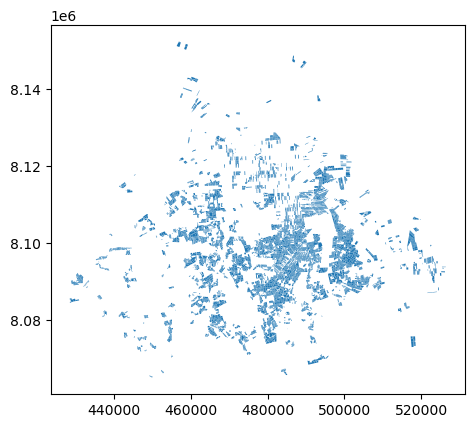

In [8]:
catastro.plot()
plt.show()

## Leer data de codigos de cosecha

In [8]:
# open file dialog
#root = tk.Tk()
#root.attributes('-topmost', True)
#root.iconify()
#file_name = fd.askopenfilename(parent=root, filetypes=[(".xlsx", ".xlsx")])
#root.destroy()

In [9]:
codcos_filename = 'G:\\Ingenio Azucarero Guabira S.A\\UTEA - SEMANAL - AVANCE COSECHA\\2023\\ANALISIS DE CAÑA EN CAMPO 2023\\GRUPO COSECHA 2023.xlsx'
codcos_filename

'G:\\Ingenio Azucarero Guabira S.A\\UTEA - SEMANAL - AVANCE COSECHA\\2023\\ANALISIS DE CAÑA EN CAMPO 2023\\GRUPO COSECHA 2023.xlsx'

In [10]:
data_cod_cosecha = pd.read_excel(codcos_filename)

## Leer codigos de grupo

In [11]:
cod_cos = 462
# lista de propiedades de grupo cañerp
propiedades = [1735]

In [12]:
grupo = data_cod_cosecha[data_cod_cosecha['COD COSECHA']==cod_cos]

In [13]:
delegado = grupo[grupo['DELEGADO'] == 'DELEGADO']
if (len(delegado) == 1):
    cod_ca_delegado = delegado.iloc[0]['CODIGO CAÑERO']
    nom_ca_delegado = delegado.iloc[0]['NOMBRE CAÑERO']
else:
    print('Error al seleccionar delegado')

In [14]:
cods_ca = list(grupo['CODIGO CAÑERO'])
cods_ca

[13042]

In [15]:
lista_ca = []
for i in cods_ca:
    cod_ca = data_cod_cosecha[data_cod_cosecha['CODIGO CAÑERO'] == i].iloc[0]['CODIGO CAÑERO']
    nom_ca = data_cod_cosecha[data_cod_cosecha['CODIGO CAÑERO'] == i].iloc[0]['NOMBRE CAÑERO']
    dict_ca = { 'cod_ca' : cod_ca, 'nom_ca' : nom_ca }
    lista_ca.append(collections.namedtuple("canhero", dict_ca.keys())(*dict_ca.values()))
lista_ca

[canhero(cod_ca=13042, nom_ca='SUAREZ DEMIQUEL OSCAR JORGE')]

In [16]:
def crear_cite(cod_canhero, nom_canhero, tipo_reporte):
    ruta_api_google = ruta + '\_keys\client_secret_google_sheets.json'
    # Configura las credenciales
    scope = ["https://spreadsheets.google.com/feeds",
             'https://www.googleapis.com/auth/spreadsheets', 
             "https://www.googleapis.com/auth/drive.file", 
             "https://www.googleapis.com/auth/drive"]
    creds = ServiceAccountCredentials.from_json_keyfile_name(ruta_api_google, scope)
    client = gspread.authorize(creds)
    # Abre la hoja de cálculo con ID y la hoja específica
    spreadsheet = client.open_by_key("1JROdo_Mjx6267cDfFvTFvhk1aE2_XTc28PfTgRxfwNQ")
    sheet = spreadsheet.sheet1
    # Lee los datos
    data_sheet = sheet.get_all_records()
    df = pd.DataFrame(data_sheet)
    # Encuentra el número más grande y lo incrementamos y agrega un nuevo registro
    max_value = df['No'].max()
    no = int(max_value + 1)
    # llenamos los demas campos
    fecha = datetime.now().strftime("%m/%d/%Y")
    cod_ca = int(cod_canhero)
    nom_ca = nom_canhero
    tipo = tipo_reporte
    #agregar el registro
    sheet.append_row([no, fecha, cod_ca, nom_ca, tipo])
    return no

In [17]:
cite = crear_cite(cod_ca_delegado, nom_ca_delegado, 'INB')

In [18]:
# crear diccionario con datos de cañeros y propiedades
fecha = datetime.now()
fecha = fecha.strftime("%d/%m/%Y")
datos_ca = { 'fecha' : fecha, 'cite': cite, 'ca' : lista_ca}

In [19]:
data = collections.namedtuple("insp", datos_ca.keys())(*datos_ca.values())
data

insp(fecha='07/02/2024', cite=11, ca=[canhero(cod_ca=13042, nom_ca='SUAREZ DEMIQUEL OSCAR JORGE')])

In [23]:
#QR
# Datos que quieres que contenga el QR
texto = '''
--UTEA--
--INFORME PARA BANCO--

Codigo informe: {cod_inf}
Fecha de emición: {fecha}
Nombre de Canero: {canero}
Codigo Canero: {cod_ca}
Tipo de informe: {tipo}'''\
.format(
    cod_inf=str(data.cite) + '-' + data.fecha[6:], 
    fecha=data.fecha, 
    canero=nom_ca_delegado,
    cod_ca=cod_ca_delegado,
    tipo='Informe para Banco')
# Generar el código QR
qr = qrcode.QRCode(
    version=1,
    error_correction=qrcode.constants.ERROR_CORRECT_L,
    box_size=10,
    border=4,
)
qr.add_data(texto)
qr.make(fit=True)
img = qr.make_image(fill_color="black", back_color="white")

filename_qr = 'qr_' + str(cod_ca_delegado) + '_' + data.fecha.replace('/', '-')
ruta_qr = ruta + '/planos/' + filename_qr + '.png'
#Guardar el código QR en un archivo
img.save(ruta_qr)

In [25]:
ruta_qr

'G:\\OneDrive - Ingenio Azucarero Guabira S.A\\_DATOS_PYTHON/planos/qr_13042_07-02-2024.png'

In [26]:
total_hoja = 0
total_soca = 0
total_renov = 0
total_produc = 0
total_cultivado = 0
props_obj = []
for i in propiedades:
    propiedad = catastro[catastro['unidad_01']==i]
    cod_prop = propiedad.iloc[0]['unidad_01']
    nom_prop = propiedad.iloc[0]['unidad_02'].replace('_', ' ').split('--')[0]
    hoja = propiedad[propiedad['soca']==0]['area'].sum()
    soca = propiedad[(propiedad['soca']!=0) & (propiedad['variedad']!='RENOVACION')]['area'].sum()
    renov = propiedad[propiedad['variedad']=='RENOVACION']['area'].sum()
    produc = hoja + soca
    cultivado = hoja + soca + renov
    
    total_hoja += hoja
    total_soca += soca
    total_renov += renov
    total_produc += produc
    total_cultivado += cultivado
    
    # seleccionar las columnas
    prop_data = propiedad[['unidad_05', 'area', 'variedad', 'fs', 'soca', 'textura']]
    # cambiar nombre de comlumnas
    prop_table = prop_data.rename(columns={'unidad_05':'lote', 'area':'area', 'variedad':'variedad', 'fs':'fs', 'soca':'corte', 'textura':'textura'})
    # truncar a dos decimales
    prop_table['area'] = prop_table['area'].round(decimals=2)
    # formato de fecha
    prop_table['fs'] = pd.to_datetime(prop_table['fs']).dt.strftime('%d/%m/%Y')
    
    lista_lotes = []
    for i in range(len(prop_table)):
        lote = prop_table.iloc[i].to_dict()
        if(lote['variedad'] == 'RENOVACION'):
            lote['fs'] = ''
            lote['corte'] = ''
        lote = collections.namedtuple("lote", lote.keys())(*lote.values())
        lista_lotes.append(lote)
    
    propiedad_dict = { 
        'cod_prop' : cod_prop,
        'nom_prop' : nom_prop,
        'hoja' : hoja, 
        'soca' : soca, 
        'renov' : renov,
        'produc' : produc,
        'cultivado' : cultivado,
        'lotes' : lista_lotes}
    props_obj.append(collections.namedtuple("propiedad", propiedad_dict.keys())(*propiedad_dict.values()))

In [28]:
totales = { 
    't_hoja': total_hoja,
    't_soca' : total_soca,
    't_renov' : total_renov,
    't_produc': total_produc,
    't_cultivado' : total_cultivado}

In [29]:
total = collections.namedtuple("total", totales.keys())(*totales.values())

In [31]:
doc = DocxTemplate(ruta+"/templates/tpl_informe_banco.docx")
in_line_qr = docxtpl.InlineImage(doc, image_descriptor=ruta_qr, width=Mm(30))
context = {'insp' : data, 'propiedades' : props_obj, 'total' : total, 'qr':in_line_qr}
doc.render(context)
file_name = str(cod_ca_delegado) + '_INB_' + data.fecha.replace('/', '-') + '_' + nom_ca_delegado
doc.save(ruta + '/informes/_' + file_name + '.docx')